<a href="https://colab.research.google.com/github/LCaravaggio/politext/blob/main/LASSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
base=pd.read_csv('/content/drive/MyDrive/base_formateada.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle

with open('/content/drive/MyDrive/vocabulary.voc', 'rb') as f:
    inter = pickle.load(f)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,2) ,vocabulary=inter)
matrix = cv.fit_transform(base['tokens'])

# Bases nuevas

In [4]:
# Esta celda tarda casi una hora en correr
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=30, max_iter=50, learning_method='batch', learning_offset=50.,random_state=0)  
lda.fit(matrix)

KeyboardInterrupt: ignored

In [ ]:
disc_weights=matrix*lda.components_.transpose()
base['Topic_weight']=disc_weights.argmax(axis=1)+1

In [ ]:
disc_weights.shape

In [ ]:
base[['apellido', 'nombre']] =base.namey.str.split(', ', expand=True)

In [ ]:
column_names = [str(i) for i in range(1, 31)]

df_weights = pd.DataFrame(disc_weights, columns=column_names)

select=[ 'fecha', 'apellido', 'nombre' , 'intervention'	, 'party', 'role']
df_weights = pd.concat([base[select], df_weights], axis=1)

In [ ]:
df_weights.to_csv('df_weights.csv')

In [ ]:
import scipy as sp
from scipy.special import logsumexp

def frex(mod, w=0.7):
    log_beta = np.log(mod.components_)
    log_exclusivity = log_beta - logsumexp(log_beta, axis=0)
    exclusivity_ecdf = np.apply_along_axis(ecdf, 1, log_exclusivity)
    freq_ecdf = np.apply_along_axis(ecdf, 1, log_beta)
    out = 1. / (w / exclusivity_ecdf + (1 - w) / freq_ecdf)
    return out
  
def ecdf(arr):
    return sp.stats.rankdata(arr, method='max') / arr.size

In [ ]:
import numpy as np
frex_df=pd.DataFrame(frex(lda))
disc_frex=matrix*frex_df.transpose()

In [ ]:
df_frex = pd.DataFrame(disc_frex, columns=column_names)

select=[ 'fecha', 'apellido', 'nombre' , 'intervention'	, 'party', 'role']
df_frex = pd.concat([base[select], df_frex], axis=1)

In [ ]:
df_frex.to_csv('df_frex.csv')

In [ ]:
from google.colab import files
files.download('df_frex.csv')
files.download('df_weights.csv')

# LASSO

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy import argsort

n=20
macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(base.loc[:, base.columns != 'party'], base['party'], test_size=0.33, random_state=42)
train_matrix = cv.fit_transform(X_train['tokens'])
test_matrix = cv.transform(X_test['tokens'])  
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix )
macro.append(f1_score(predictions,y_test, average='macro'))
weighted.append(f1_score(predictions,y_test, average='weighted'))

In [ ]:
lasso=pd.DataFrame()
lasso['negativos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[:20]]
lasso['positivos']=cv.get_feature_names_out()[argsort(lr.coef_[0])[-20:]]

In [ ]:
lasso.to_csv('lasso.csv')

# LASSO por legislatura

In [ ]:
# Relevancia de bigramas en la predicción por legislatura
tabla=[]
legislaturas=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII','VIII', 'IX', 'X', 'XI', 'XII','XIII']
n=20

macro=[]
weighted=[]

lr = LogisticRegression(penalty='l1', max_iter=50, solver='liblinear')

lasso=pd.DataFrame()

for x in legislaturas: 
  base_year=base[base.legislatura==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])  
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s=lr.coef_[0]
  lasso[f"Legislatura: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Legislatura: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [ ]:
lasso.to_csv('lasso_por_legislatura.csv')

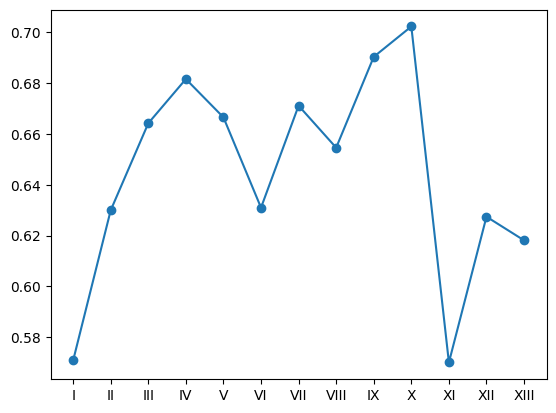

In [ ]:
import matplotlib.pyplot as plt
plt.plot(legislaturas, macro, marker='o')
plt.savefig('lasso_por_legislatura.png')

# LASSO por año

In [ ]:
base.fecha=pd.to_datetime(base.fecha, infer_datetime_format=True)

In [ ]:
# Relevancia de bigramas en la predicción por año
macro=[]
weighted=[]

nombres=cv.get_feature_names_out()

n = 20
lr = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')


lasso=pd.DataFrame()

for x in range (1979, 2020): 
  base_year=base[pd.DatetimeIndex(base.fecha).year==x]
  X_train, X_test, y_train, y_test = train_test_split(base_year.loc[:, base_year.columns != 'party'], base_year['party'], test_size=0.33, random_state=42)
  train_matrix = cv.fit_transform(X_train['tokens'])
  test_matrix = cv.transform(X_test['tokens'])  
  lr.fit(train_matrix,y_train)
  predictions = lr.predict(test_matrix )
  macro.append(f1_score(predictions,y_test, average='macro'))
  weighted.append(f1_score(predictions,y_test, average='weighted'))
  s = lr.coef_[0]
  lasso[f"Año: {x} - neg"] = cv.get_feature_names_out()[argsort(s)[:n]]
  lasso[f"Año: {x} - pos"] = cv.get_feature_names_out()[argsort(s)[-n:]]

In [ ]:
lasso.to_csv('lasso_por_año.csv')

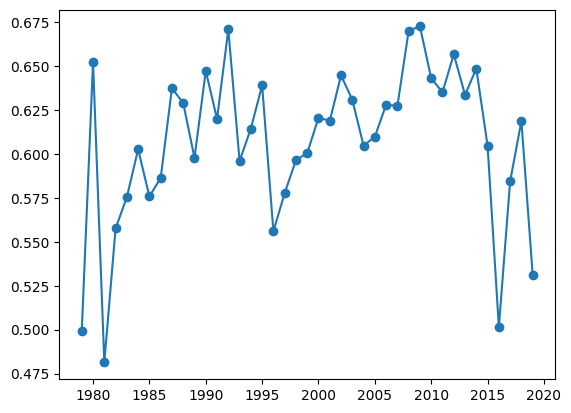

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1979,2020), macro, marker='o')
plt.savefig('lasso_por_año.png')

# LASSO por Semana

In [ ]:
len((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique())

1164

In [ ]:
base['semana']=pd.Series(pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).values


In [ ]:
# Esta celda demora unos 25 minutos en correr
import numpy as np
lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str) + '-' + pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), name='semana'))
#lasso = pd.DataFrame(columns=[f"neg-{x}" for x in range(1, 21)] + [f"pos-{x}" for x in range(1, 21)], index=pd.Index(('1979-12','2019-35'), name='semana'))
macro=[]
weighted=[]

for x in lasso.index:
    try:
      base_semana = base[base['semana'] == x]
      X_train, X_test, y_train, y_test = train_test_split(base_semana.loc[:, base_semana.columns != 'party'], base_semana['party'], test_size=0.33, random_state=42)
      train_matrix = cv.fit_transform(X_train['tokens'])
      test_matrix = cv.transform(X_test['tokens'])  
      lr.fit(train_matrix, y_train)
      predictions = lr.predict(test_matrix)
      s = lr.coef_[0]
      neg_features = cv.get_feature_names_out()[np.argsort(s)[:20]]
      pos_features = cv.get_feature_names_out()[np.argsort(s)[-20:]]
      lasso.loc[x, [f"neg-{i+1}" for i in range(20)]] = neg_features
      lasso.loc[x, [f"pos-{i+1}" for i in range(20)]] = pos_features
      
      predictions = lr.predict(test_matrix )
      macro.append(f1_score(predictions,y_test, average='macro'))
      weighted.append(f1_score(predictions,y_test, average='weighted'))
    except: 
      macro.append(np.nan)
      weighted.append(np.nan)  


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
lasso.to_csv('lasso_por_semana.csv')

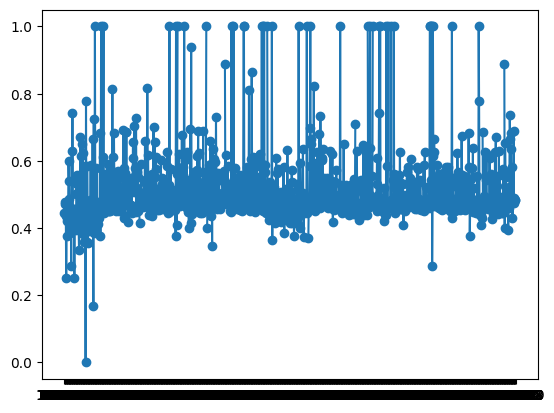

In [ ]:
import matplotlib.pyplot as plt
plt.plot((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), macro, marker='o')

plt.savefig('lasso_por_semana.png')

In [ ]:
lasso['macro']=macro

In [ ]:
# Estas son las semanas que tienen macro==1
lasso.index[lasso['macro'] == 1]

Index(['1981-50', '1982-25', '1982-52', '1989-5', '1989-47', '1990-2',
       '1990-35', '1992-27', '2001-36', '2001-42', '2002-34', '2002-35',
       '2003-49', '2003-52', '1996-13', '1996-36', '1996-52', '1999-18',
       '2000-5', '1993-42', '2004-33', '2006-36', '2006-44', '2007-3',
       '2007-29', '2007-31', '2008-5', '2008-15', '2008-27', '2008-43',
       '2011-34', '2011-35', '2011-42', '2011-44', '2012-2', '2013-31',
       '2015-49'],
      dtype='object', name='semana')

In [ ]:
# Una sola semana tiene macro==0
lasso.index[lasso['macro'] == 0]

Index(['1981-1'], dtype='object', name='semana')

In [ ]:
base[base.semana=='1981-1']

,Unnamed: 0,orden,namex,intervention,fecha,legislatura,pleno,role,oradorx,namey,...,congreso,senado,total,oradory,cataluna,estatut,inter_raw,partido,tokens,semana
5387,5387,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUCH MARTIN,Para turno a favor.,1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUCH MARTIN,"Lluch Martín, Ernest †",...,"4 (C, I, II, III)",–,4.0,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,[],1981-1
5388,5388,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUUCH MARTIN,"Señor Presidente, señoras Diputadas, señores ...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUUCH MARTIN,"Lluch Martín, Ernest †",...,"4 (C, I, II, III)",–,4.0,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,"['señora', 'diputada', 'señor', 'diputado', 'm...",1981-1
5389,5389,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,GARCIA-MARGALLO MARFIL,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",GARCIA-MARGALLO MARFIL,"García-Margallo y Marfil, José Manuel",...,"7 (C, I, III, IV, V, XI, XII)",–,7.0,GARCIA-MARGALLO Y MARFIL,0.0,0.0,NaN,"UCD, CP, PP","['señora', 'señor', 'diputado', 'misma', 'brev...",1981-1
5390,5390,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,LLUCH MARTIN,"Señor Presidente, señoras Diputadas, señores ...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",LLUCH MARTIN,"Lluch Martín, Ernest †",...,"4 (C, I, II, III)",–,4.0,LLUCH MARTIN,0.0,0.0,NaN,PSC-PSOE,"['señora', 'diputada', 'señor', 'diputado', 's...",1981-1
5391,5391,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,GARCIA-MARGALLO MARFIL,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",GARCIA-MARGALLO MARFIL,"García-Margallo y Marfil, José Manuel",...,"7 (C, I, III, IV, V, XI, XII)",–,7.0,GARCIA-MARGALLO Y MARFIL,0.0,0.0,NaN,"UCD, CP, PP","['señora', 'señor', 'diputado', 'ratificar', '...",1981-1
5392,5392,ENMIENDA DEL SENADO AL PROYECTO DE LEY DE PRES...,BARON CRESPO,"Señor Presidente, señoras y señores Diputados...",1980-12-29,I,141.0,"DIPUTADO, DIPUTADA",BARON CRESPO,"Barón Crespo, Enrique",...,"4 (C, I, II, III)",–,4.0,BARON CRESPO,0.0,0.0,NaN,PSOE,"['señora', 'señor', 'diputado', 'aprobado', 'p...",1981-1
5393,5393,ELFOCION DE MAGISTRADO DEL TRIBUNAL CONSTITUCI...,VICEPRESIDENTE (Fraile Poujade),Vamos a comenzar el escrutinio. (Pausa.) Pre...,1980-12-29,I,141.0,"VICEPRESIDENTE, VICEPRESIDENTA",FRAILE POUJADE,"Fraile Poujade, Modesto †",...,"4 (C, I, II, III)",–,4.0,FRAILE POUJADE,0.0,0.0,NaN,"UCD, AP-PDP, CP","['comenzar', 'escrutinio', 'pausa', 'previamen...",1981-1


In [ ]:
# Estas son las semanas en las que el macro es > 0.8
lasso.index[lasso['macro'] > 0.8]

Index(['1981-50', '1982-25', '1982-52', '1983-41', '1986-52', '1989-5',
       '1989-47', '1990-2', '1990-35', '1991-12', '1992-27', '2001-4',
       '2001-36', '2001-42', '2002-34', '2002-35', '2003-4', '2003-12',
       '2003-49', '2003-52', '1996-13', '1996-36', '1996-52', '1999-18',
       '2000-5', '1993-42', '1994-3', '2004-33', '2006-36', '2006-44',
       '2007-3', '2007-29', '2007-31', '2008-5', '2008-15', '2008-27',
       '2008-43', '2011-34', '2011-35', '2011-42', '2011-44', '2012-2',
       '2013-31', '2015-49', '2018-29'],
      dtype='object', name='semana')

# Asignacion de Topic por semana

In [ ]:
import statistics as st
a=[]
for x in lasso.index:
      a.append(st.mode(base[base['semana'] == x]['Topic_weight']))

In [ ]:
topic_semana=pd.DataFrame(lasso['macro'])

In [ ]:
topic_semana['topic']=a

In [ ]:
topic_semana.to_csv('topic_por_semana.csv')

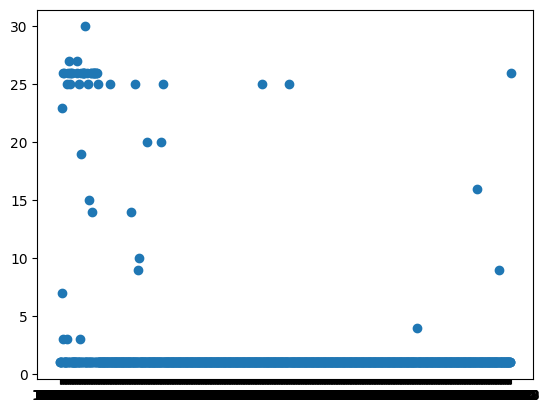

In [ ]:
import matplotlib.pyplot as plt
plt.scatter((pd.DatetimeIndex(base.fecha).isocalendar().year.astype(str)  +'-'+ pd.DatetimeIndex(base.fecha).isocalendar().week.astype(str)).unique(), topic_semana['topic'], marker='o')
plt.savefig('topic_por_semana.png')

In [ ]:
# Estas son las semanas en las que se habló de temas distintos al Topic 1.
topic_semana.index[topic_semana['topic'] != 1]

Index(['1979-20', '1979-21', '1979-22', '1979-24', '1979-25', '1979-43',
       '1979-45', '1979-47', '1979-50', '1980-5', '1980-7', '1980-9',
       '1980-13', '1980-38', '1980-39', '1980-46', '1980-49', '1980-51',
       '1981-1', '1981-12', '1981-13', '1981-14', '1981-17', '1981-20',
       '1981-25', '1981-39', '1981-44', '1981-50', '1982-6', '1982-8',
       '1982-11', '1982-13', '1982-16', '1982-17', '1982-23', '1982-24',
       '1982-26', '1982-47', '1983-49', '1985-41', '1986-5', '1986-17',
       '1986-31', '1987-20', '1988-40', '1988-49', '1996-30', '1999-3',
       '2011-3', '2016-33', '2018-28', '2019-49'],
      dtype='object', name='semana')